<a href="https://colab.research.google.com/github/wayneleehan/AI-learning/blob/main/%E7%A8%8B%E5%BC%8F%E4%BA%A4%E6%98%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader
import pandas as pd
import numpy as np
import backtrader as bt
import warnings
warnings.filterwarnings('ignore')
!pip install jieba

In [ ]:
# 讀取數據
df = pd.read_csv("2454_stock_price.csv", parse_dates=['年月日'], encoding='big5')

# 將內容重新命名方便之後運算
df.rename(columns={
    '年月日': 'Date',
    '開盤價(元)': 'Open',
    '最高價(元)': 'High',
    '最低價(元)': 'Low',
    '收盤價(元)': 'Close',
    '成交量(千股)': 'Volume'
}, inplace=True)
df.set_index('Date', inplace=True)

# 使用backtrader內建指標計算rsi 14以資料收盤價為基礎
df['RSI'] = bt.indicators.RSI_SMA(df['Close'], period=14)

# 使用pandas的ewm計算20天價格變化 adjust false為不進行調整
df['EMA'] = df['Close'].ewm(span=20, adjust=False).mean()
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

# 簡易atr測試市場波動
df['ATR'] = df['High'] - df['Low']

# 將年份進行切割
years = df.index.year.unique()
results = {}

In [ ]:
class BaseStrategy(bt.Strategy):
    params = dict(
        risk_per_trade=0.1,  # 每次交易投入 10% 本金
        atr_mult=1.5,  # ATR乘數
        take_profit_mult=3  # 盈利目標倍數
    )

    def __init__(self): # 初始化變數指標 確保之後交易正常
        self.trades = [] # 紀錄發生交易
        self.start_value = self.broker.getvalue() # 記錄初始資金
        self.year = self.data.datetime.date(0).year # 確認當前交易資料屬於哪個年份
        self.last_buy_price = None
        self.stop_loss = None # 止損
        self.take_profit = None # 止盈
        self.atr = bt.indicators.ATR(period=14) # 初始化atr指標
        self.results = {} # 儲存年度交易結果

    def log_trade(self, trade_type, size, pnl=0): # 紀錄每一筆交易資訊
        self.trades.append({
            'date': self.data.datetime.date(0), # 日期
            'trade': trade_type, # 購買or賣出
            'price': self.data.close[0], # 購買價格
            'size': size, # 股數
            'cash': self.broker.get_cash(), # 金額
            'pnl': pnl # 獲利金額
        })

    def notify_order(self, order):
        if order.status in [order.Completed, order.Partial]:  # 確認訂單是否成交
            trade_type = "BUY" if order.isbuy() else "SELL" # 將購買資料計入
            self.log_trade(trade_type, order.executed.size, pnl=(self.broker.get_value() - self.start_value))

            if order.isbuy(): # 訂單完成時 止損or止盈
                self.last_buy_price = order.executed.price # 紀錄成交價格
                self.stop_loss = self.last_buy_price - (self.atr[0] * self.params.atr_mult)  # 止損價格＝買入價格-(ATR * ATR 乘數)
                self.take_profit = self.last_buy_price + (self.atr[0] * self.params.take_profit_mult)  # 止盈價格＝買入價格+(atr * 止盈倍數)

    def stop(self): # 回測結束時計算績效指標
        pnl = self.broker.get_value() - self.start_value # 總盈虧
        total_trades = sum(1 for t in self.trades if t['trade'] in ["BUY", "SELL"])  # 交易次數
        win_trades = [t for t in self.trades if t['trade'] == "SELL" and t['price'] > self.last_buy_price] # 獲勝交易數量
        loss_trades = [t for t in self.trades if t['trade'] == "SELL" and t['price'] <= self.last_buy_price] # 失敗交易數量

        win_rate = len(win_trades) / len(self.trades) if self.trades else 0 # 計算勝率
        avg_win = np.mean([t['price'] for t in win_trades]) if win_trades else 0 # 從win trade中計算平均獲利價格
        avg_loss = np.mean([t['price'] for t in loss_trades]) if loss_trades else 0 # 從loss trade中計算平均虧損價格

        profit_loss_ratio =  (avg_win / avg_loss) if avg_loss else float('inf') if win_trades else 0 # 計算盈虧比

        self.results = { # 儲存回測績效指標
            'Year': self.year, # 年份
            'Final Value': self.broker.get_value(), # 最終資產
            'Annual Return': (self.broker.get_value() / self.start_value - 1) * 100, # 年回報
            'Win Rate': win_rate * 100, # 勝率
            'Profit/Loss Ratio': profit_loss_ratio, # 盈虧比
            'Total Trades': total_trades, # 交易次數
        }

class RSIStrategy(BaseStrategy):  # 不同策略繼承 BaseStrategy
    def __init__(self):  # 初始化
        super().__init__()
        self.rsi = bt.indicators.RSI(period=14)
        self.last_trade_date = None  # 追蹤上次交易的日期

    def next(self):
        current_date = self.data.datetime.date(0)  # 當前交易日

        # 若尚未交易過或上次交易距離現在已超過三天
        if self.last_trade_date is None or (current_date - self.last_trade_date).days > 3:
            if self.rsi[0] < 30:  # RSI 低於 30，買進
                    size = (self.broker.get_cash() * self.params.risk_per_trade) // self.data.close[0]
                    self.buy(size=size)
                    self.last_trade_date = current_date  # 更新最後交易日期
            elif self.rsi[0] > 70:  # RSI 高於 70，賣出
                self.sell(size=self.position.size)
                self.last_trade_date = current_date  # 更新最後交易日期

class MACDStrategy(BaseStrategy):
    def __init__(self):  # 初始化
        super().__init__()
        self.macd = bt.indicators.MACD()
        self.last_trade_date = None  # 追蹤上次交易的日期

    def next(self):  # 會在每一個交易日重新呼叫一次
        current_date = self.data.datetime.date(0)  # 當前交易日

        # 若尚未交易過或上次交易距離現在已超過三天
        if self.last_trade_date is None or (current_date - self.last_trade_date).days > 3:
            if self.macd.macd[0] > self.macd.signal[0]:  # 黃金交叉買入
                    # 買入數量 = 可用資金 * 風險比例（本金 10%）/ 當前股價
                    size = (self.broker.get_cash() * self.params.risk_per_trade) // self.data.close[0]
                    self.buy(size=size)
                    self.last_trade_date = current_date  # 更新最後交易日期
            elif self.macd.macd[0] < self.macd.signal[0]:  # 死亡交叉賣出
                self.sell(size=self.position.size)
                self.last_trade_date = current_date  # 更新最後交易日期

class EMAStrategy(BaseStrategy):
    def __init__(self):  # 初始化
        super().__init__()
        self.ema = bt.indicators.EMA(period=20)  # 計算20日EMA
        self.last_trade_date = None  # 追蹤上次交易的日期

    def next(self):
        current_date = self.data.datetime.date(0)  # 當前交易日

        # 若尚未交易過或上次交易距離現在已超過三天
        if self.last_trade_date is None or (current_date - self.last_trade_date).days > 3:
            # 當收盤價大於 EMA 時買進
            if self.data.close[0] > self.ema[0]:
                size = (self.broker.get_cash() * self.params.risk_per_trade) // self.data.close[0]
                self.buy(size=size)
                self.last_trade_date = current_date  # 更新最後交易日期

            # 當收盤價小於 EMA 時賣出（若有持倉）
            elif self.data.close[0] < self.ema[0]:
                self.sell(size=self.position.size)
                self.last_trade_date = current_date  # 更新最後交易日期

class ATRStrategy(BaseStrategy):
    def __init__(self):  # 初始化
        super().__init__()
        self.atr = bt.indicators.ATR(period=14)
        self.last_trade_date = None  # 追蹤上次交易的日期

    def next(self):
        current_date = self.data.datetime.date(0)  # 當前交易日

        # 若尚未交易過或上次交易距離現在已超過三天
        if self.last_trade_date is None or (current_date - self.last_trade_date).days > 3:
            if self.atr[0] > self.atr[-1]:  # 若 ATR 增加，買進
                size = (self.broker.get_cash() * self.params.risk_per_trade) // self.data.close[0]
                self.buy(size=size)
                self.last_trade_date = current_date  # 更新最後交易日期
            elif self.atr[0] < self.atr[-1]:  # 若 ATR 減少，賣出
                self.sell(size=self.position.size)
                self.last_trade_date = current_date  # 更新最後交易日期

In [ ]:
class myStrategy(BaseStrategy):
    def __init__(self):  # 初始化 並繼承技術指標
        super().__init__()
        self.ema = bt.indicators.EMA(period=20)  # 計算EMA
        self.macd = bt.indicators.MACD()  # 計算MACD
        self.atr = bt.indicators.ATR(period=14)  # 計算ATR
        self.last_trade_date = None  # 追蹤上次交易的日期

    def next(self):  # 交易邏輯
        current_date = self.data.datetime.date(0)  # 當前交易日

        # 若尚未交易過或上次交易距離現在已超過三天
        if self.last_trade_date is None or (current_date - self.last_trade_date).days > 3:
                # 當 MACD 黃金交叉 且 價格在 EMA 之上，買進
            if self.macd.macd[0] > self.macd.signal[0] and self.data.close[0] > self.ema[0]:
                    size = (self.broker.get_cash() * self.params.risk_per_trade) // self.data.close[0]
                    self.buy(size=size)
                    self.last_trade_date = current_date  # 更新最後交易日期
                # 當 MACD 死亡交叉 且 價格跌破 EMA，賣出
            elif self.macd.macd[0] < self.macd.signal[0] and self.data.close[0] < self.ema[0]:
                    self.sell(size=self.position.size)
                    self.last_trade_date = current_date  # 更新最後交易日期

In [ ]:
results = {}

for year in years:
    df_year = df[df.index.year == year]
    strategies = {'RSI': RSIStrategy,
                  'MACD': MACDStrategy,
                  'EMA': EMAStrategy,
                  'ATR': ATRStrategy,
                  'MYS':myStrategy
    }

    for strat_name, strat_class in strategies.items():
        cerebro = bt.Cerebro()
        cerebro.broker.set_cash(1_000_000)  # 初始資金 100 萬

        # 1. 明確指定數據列映射（包含Volume）
        data = bt.feeds.PandasData(
            dataname=df_year,
            open='Open',
            high='High',
            low='Low',
            close='Close',
            openinterest=None
        )
        cerebro.adddata(data)  # 2. 添加數據

        cerebro.addstrategy(strat_class)  # 3. 添加策略

        # 繼續執行回測...
        initial_value = cerebro.broker.getvalue()
        strat = cerebro.run()[0]
        final_value = cerebro.broker.getvalue()

        strat = cerebro.runstrats[0][0]
        total_trades = strat.results.get('Total Trades', 0)

        # 存績效數據
        result = {
            'Year': year,
            'Strategy': strat_name,
            'Final Value': final_value,
            'Annual Return': (final_value / initial_value - 1) * 100,
            'Win Rate': strat.results['Win Rate'],
            'Profit/Loss Ratio': strat.results['Profit/Loss Ratio'],
            'Total Trades': total_trades
        }
        results[f"{year}_{strat_name}"] = result

        print(f"\n{year} - {strat_name} 結果:")
        print(f"年化報酬率: {result['Annual Return']:.2f}%")
        print(f"最終資金: {result['Final Value']:.2f}")
        print(f"勝率: {result['Win Rate']:.2f}%")
        print(f"盈虧比: {result['Profit/Loss Ratio']:.2f}")
        print(f"換倉次數: {result['Total Trades']} 次")

# 儲存所有績效數據
performance_df = pd.DataFrame(results.values())
pd.DataFrame(results.values()).to_csv("strategy_performance.csv", index=False)


2008 - RSI 結果:
年化報酬率: 7.85%
最終資金: 1078467.50
勝率: 7.69%
盈虧比: inf
換倉次數: 13 次

2008 - MACD 結果:
年化報酬率: 0.42%
最終資金: 1004160.50
勝率: 20.93%
盈虧比: inf
換倉次數: 43 次

2008 - EMA 結果:
年化報酬率: -9.04%
最終資金: 909611.00
勝率: 20.00%
盈虧比: 1.63
換倉次數: 40 次

2008 - ATR 結果:
年化報酬率: 5.09%
最終資金: 1050891.00
勝率: 31.48%
盈虧比: 1.66
換倉次數: 54 次

2008 - MYS 結果:
年化報酬率: -1.81%
最終資金: 981921.50
勝率: 18.75%
盈虧比: inf
換倉次數: 32 次

2009 - RSI 結果:
年化報酬率: 0.00%
最終資金: 1000000.00
勝率: 0.00%
盈虧比: 0.00
換倉次數: 0 次

2009 - MACD 結果:
年化報酬率: 1.82%
最終資金: 1018236.00
勝率: 0.00%
盈虧比: 0.00
換倉次數: 33 次

2009 - EMA 結果:
年化報酬率: 8.01%
最終資金: 1080149.00
勝率: 0.00%
盈虧比: 0.00
換倉次數: 61 次

2009 - ATR 結果:
年化報酬率: -1.18%
最終資金: 988218.00
勝率: 2.04%
盈虧比: 1.28
換倉次數: 49 次

2009 - MYS 結果:
年化報酬率: 1.66%
最終資金: 1016604.00
勝率: 0.00%
盈虧比: 0.00
換倉次數: 35 次

2010 - RSI 結果:
年化報酬率: -0.13%
最終資金: 998687.00
勝率: 0.00%
盈虧比: 0.00
換倉次數: 4 次

2010 - MACD 結果:
年化報酬率: -1.99%
最終資金: 980138.50
勝率: 12.77%
盈虧比: 1.17
換倉次數: 47 次

2010 - EMA 結果:
年化報酬率: -7.36%
最終資金: 926446.50
勝率: 22.86%
盈虧比: 1.23
換倉次數: 

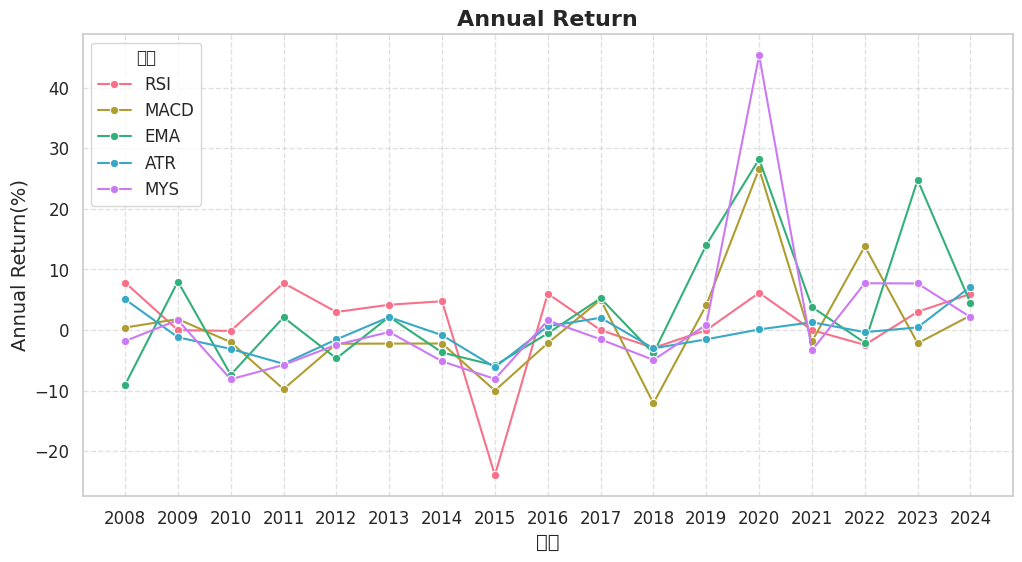

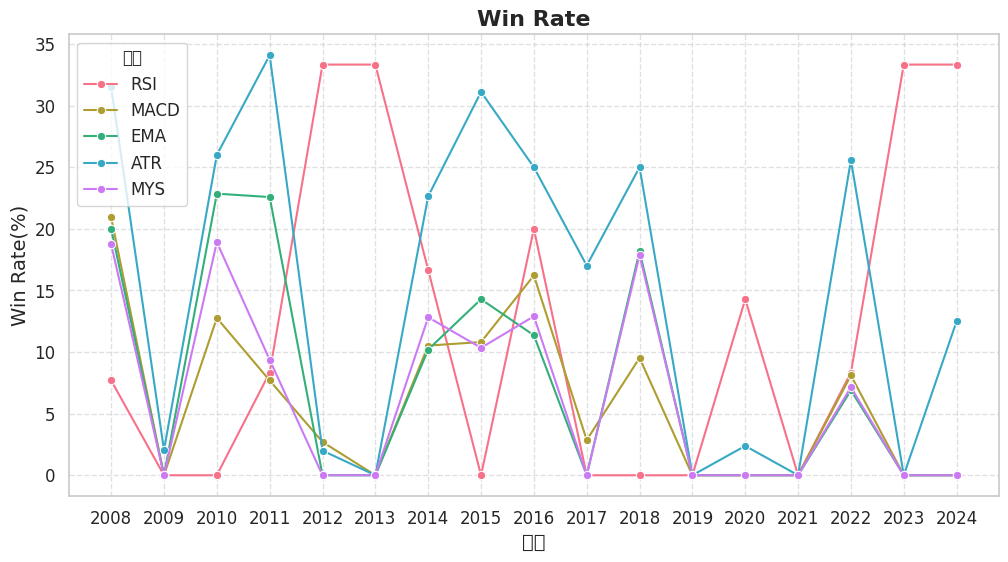

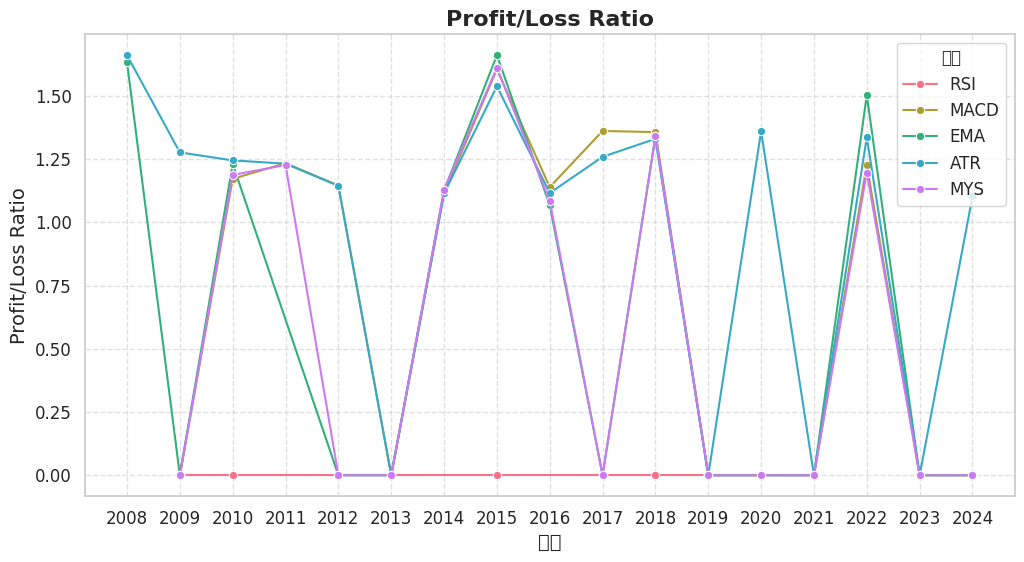

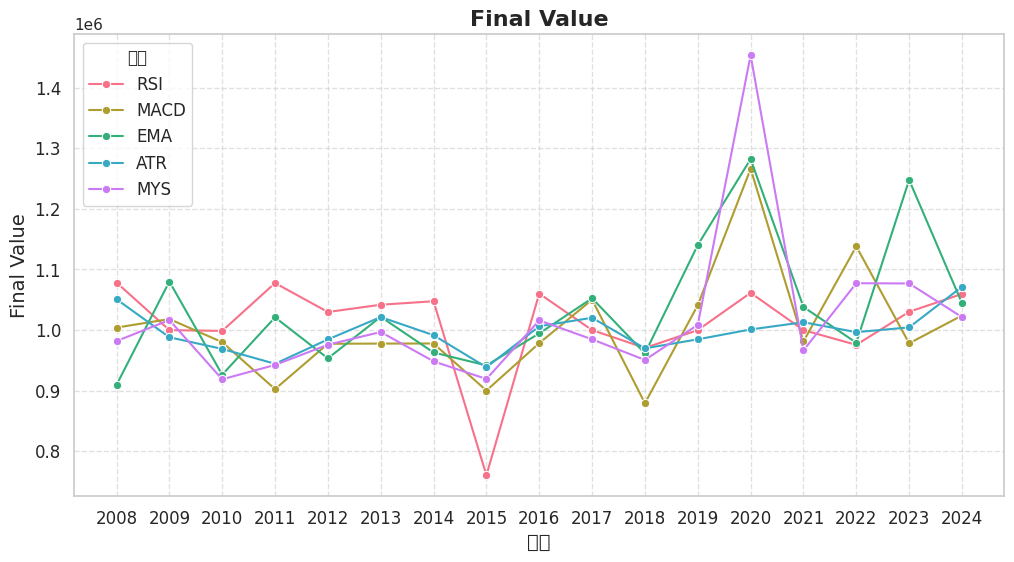

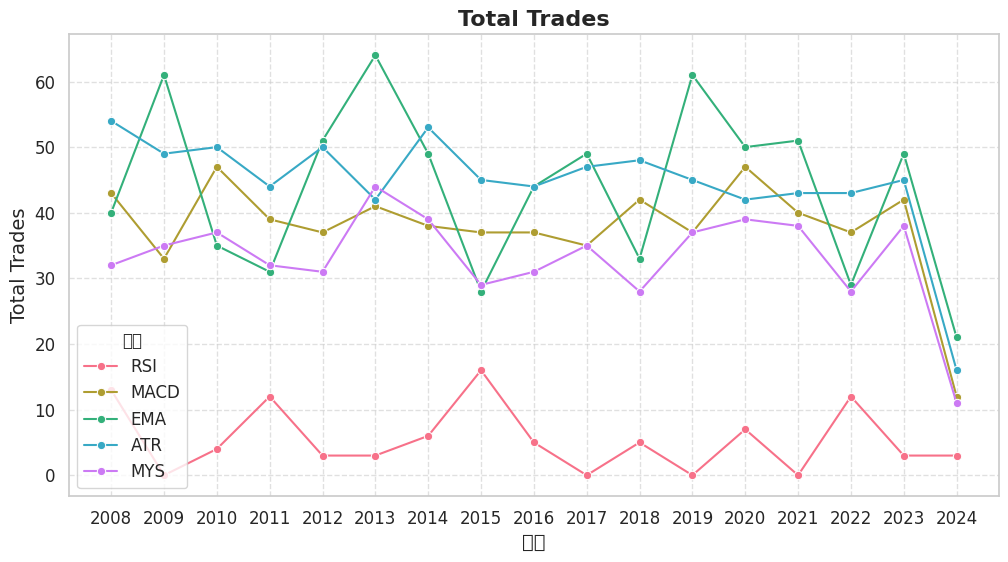

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 設定 Seaborn 風格
sns.set(style="whitegrid")

# 載入績效數據
results_df = pd.read_csv("strategy_performance.csv")

# 將年份轉為數字類型
results_df['Year'] = results_df['Year'].astype(int)

# 設定顏色，確保有足夠的顏色數量
num_strategies = len(results_df['Strategy'].unique())
colors = sns.color_palette("husl", n_colors=max(num_strategies, 10))

def plot_metric(metric, title, ylabel, add_labels=False):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results_df, x="Year", y=metric, hue="Strategy", marker="o", palette="husl")

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('年份', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(results_df['Year'].unique(), fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(title="策略", fontsize=12, frameon=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_metric('Annual Return', 'Annual Return', 'Annual Return(%)', add_labels=False)
plot_metric('Win Rate', 'Win Rate', 'Win Rate(%)', add_labels=False)
plot_metric('Profit/Loss Ratio', 'Profit/Loss Ratio', 'Profit/Loss Ratio', add_labels=False)
plot_metric('Final Value', 'Final Value', 'Final Value', add_labels=True)
plot_metric('Total Trades', 'Total Trades', 'Total Trades', add_labels=False)


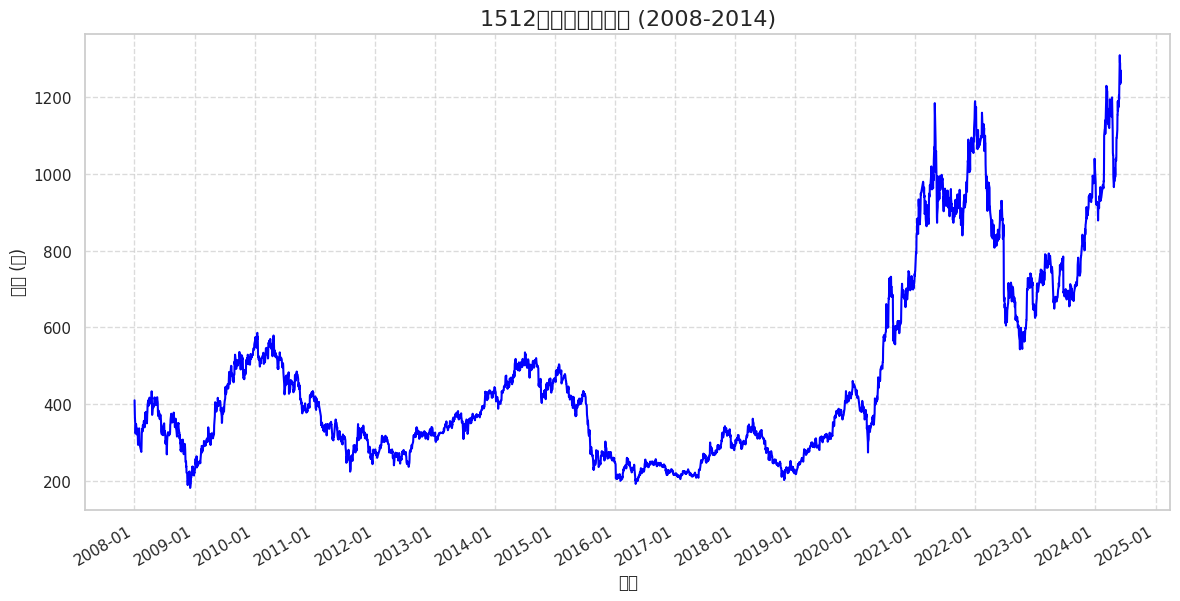

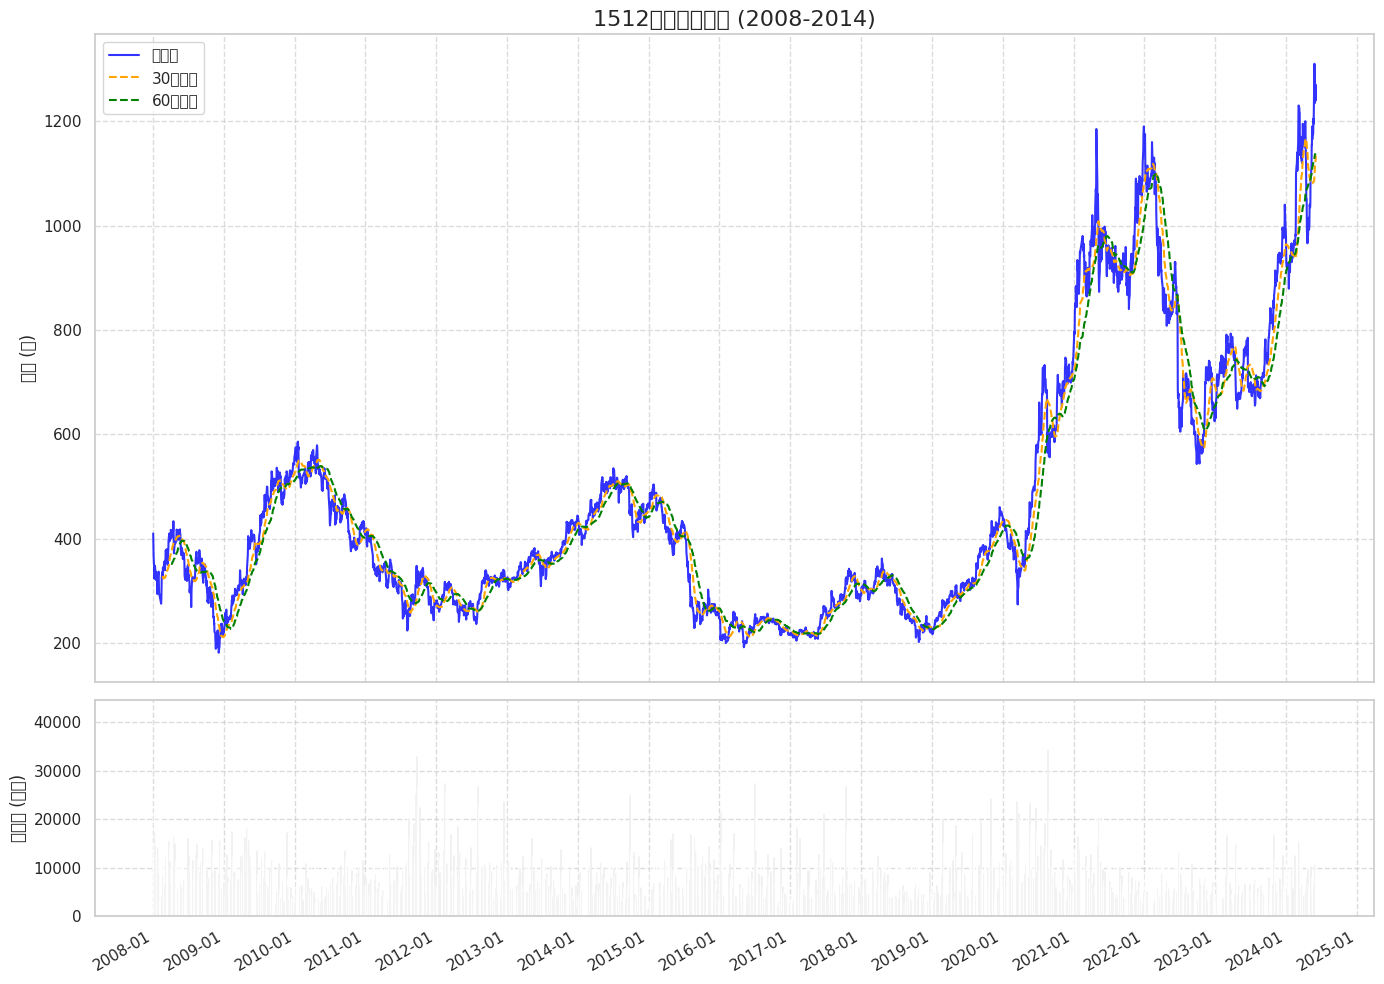

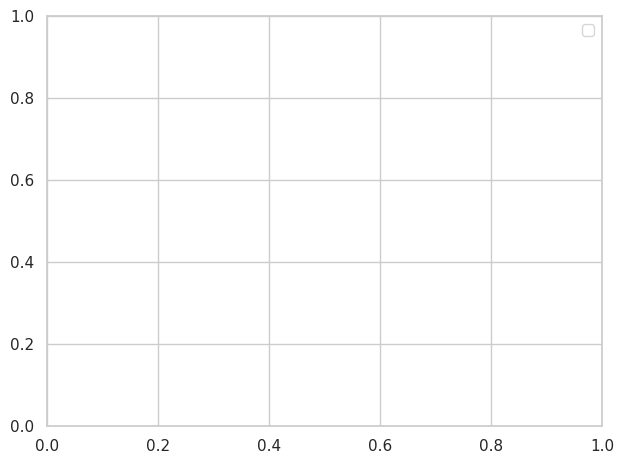

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# 設置中文字體
rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或您系統中其他支持中文的字體
rcParams['axes.unicode_minus'] = False

# 讀取數據
df = pd.read_csv("2454_stock_price.csv", parse_dates=['年月日'], encoding='big5')

# 設置日期為索引
df.set_index('年月日', inplace=True)

# 按日期排序
df.sort_index(inplace=True)

# 繪製收盤價走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['收盤價(元)'], label='收盤價', color='blue')

# 添加標題和標籤
plt.title('1512股票收盤價走勢 (2008-2014)', fontsize=16)
plt.xlabel('日期', fontsize=12)
plt.ylabel('價格 (元)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 格式化x軸日期顯示
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

# 計算30日和60日移動平均線
df['30日均線'] = df['收盤價(元)'].rolling(window=30).mean()
df['60日均線'] = df['收盤價(元)'].rolling(window=60).mean()

# 創建子圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# 繪製價格和均線
ax1.plot(df.index, df['收盤價(元)'], label='收盤價', color='blue', alpha=0.8)
ax1.plot(df.index, df['30日均線'], label='30日均線', color='orange', linestyle='--')
ax1.plot(df.index, df['60日均線'], label='60日均線', color='green', linestyle='--')

# 設置價格圖的標題和標籤
ax1.set_title('1512股票技術分析 (2008-2014)', fontsize=16)
ax1.set_ylabel('價格 (元)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# 繪製成交量
ax2.bar(df.index, df['成交量(千股)'], color='gray', alpha=0.7)
ax2.set_ylabel('成交量 (千股)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# 格式化x軸日期顯示
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

# 添加圖例
plt.legend()

plt.tight_layout()
plt.show()